## Urbanization change detection using HLS data

The tutorial leverages the access to Harmonized Landsat Sentinel-2 (HLS) data using ```CMR-STAC``` coupled with ```OpenDataCube``` to access the urbanization rate over **Austin, TX** from 2015-2024. ```OpenDataCube``` ultilizes the STAC metadata to provide an alternative way to load HLS data lazily in cloud. Using user-defined search parameters, the search method operated using ```CMR-STAC``` along with ```dask``` parallization to speed up and provide a convenient way to work with HLS data.  

Enhanced Normalised Difference Impervious Surfaces Index (ENDISI) was used to access the urbanization rate. The goal of the project is to observe HLS-derived mean ENDISI over these regions without downloading the entirety of the HLS source data.

## Background
The Harmonized Landsat Sentinel-2 (HLS) project produces seamless, harmonized surface reflectance data from the Operational Land Imager (OLI) and Multi-Spectral Instrument (MSI) aboard Landsat and Sentinel-2 Earth-observing satellites, respectively. The aim is to produce seamless products with normalized parameters, which include atmospheric correction, cloud and cloud-shadow masking, geographic co-registration and common gridding, normalized bidirectional reflectance distribution function, and spectral band adjustment. This will provide global observation of the Earth’s surface every 2-3 days with 30 meter spatial resolution. One of the major applications that will benefit from HLS is agriculture assessment and monitoring, which is used as the use case for this tutorial.


## Requirements
A NASA Earthdata Login account is required to download the data used in this tutorial. You can create an account at the link provided.


## Learning Objectives
How to work with HLS Landsat (HLSL30.002) and Sentinel-2 (HLSS30.002) data products
How to use CMR-STAC to search for HLS data
How to access and work with HLS data using ```dask``` and ```OpenDataCube```

## Data Used
Daily 30 meter (m) global HLS Sentinel-2 Multi-spectral Instrument Surface Reflectance - HLSS30.002
- The HLSS30 product provides 30 m Nadir normalized Bidirectional Reflectance Distribution Function (BRDF)-Adjusted Reflectance (NBAR) and is derived from Sentinel-2A and Sentinel-2B MSI data products.
Science Dataset (SDS) layers

Daily 30 meter (m) global HLS Landsat-8 OLI Surface Reflectance - HLSL30.002
- The HLSL30 product provides 30 m Nadir normalized Bidirectional Reflectance Distribution Function (BRDF)-Adjusted Reflectance (NBAR) and is derived from Landsat-8 OLI data products.
Science Dataset (SDS) layers



## Tutorial Outline
<font color="blue">[1. Getting started](#1.-Getting-started)</font> 
- <font color="blue">[1.1. Python Environment and Packages](#1.1.-Python-Environment-and-Packages) </font> 
- <font color="blue">[1.2. EarthData Login](#1.2.-Earthdata-Login)</font> 
- <font color="blue">[1.3. Set up Dask Client](#1.3.-Set-up-Dask-Client)</font> 
- <font color="blue">[1.4. Configure GDAL Options and rio environment](#1.4.-Configure-GDAL-Options-and-rio-environment)</font> 

<font color="blue">[2. CMR-STAC Search](#2.-CMR-STAC-Search)</font> 

<font color="blue">[3. Loading HLS data using ODC-STAC](#3.-Loading-HLS-data-using-ODC-STAC)</font> 

<font color="blue">[4. Urbanization Change Detection Analysis](#4.-Urbanization-Change-Detection-Analysis)</font> 

-----------------------------------------------------------------------------------------------------------------------------------------

# 1. Getting started


## 1.1. Python Environment and Packages

A compatible python environment can be created by following the Python Environment setup instructions, activating that environment and adding the pystac-client and odc-stac packages:



In [ ]:
mamba create -n lpdaac_vitals -c conda-forge --yes python=3.10 gdal=3.7.2 hvplot geoviews rioxarray rasterio geopandas fiona=1.9.4 jupyter earthaccess jupyter_bokeh h5py h5netcdf spectral scikit-image seaborn jupyterlab dask ray-default ray-dashboard pystac-client odc-stac


In [2]:
mamba activate lpdaac_vitals

Run 'mamba init' to be able to run mamba activate/deactivate
and start a new shell session. Or use conda to activate/deactivate.


Note: you may need to restart the kernel to use updated packages.


In [4]:
%matplotlib inline

import os
from datetime import datetime
import numpy as np
import pandas as pd
import geopandas as gp
from skimage import io
import matplotlib.pyplot as plt
from osgeo import gdal
import xarray as xr
import rioxarray as rxr
import hvplot.xarray
import hvplot.pandas
import earthaccess
import pystac_client
import dask.distributed
import odc.stac
import xarray as xr
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
%run -i ./tools/plotting.ipynb
%run -i ./tools/data_access.ipynb
%run -i ./tools/algorithm.ipynb

## 1.2. Earthdata Login

We will use the earthaccess package for authentication. <font color="blue">[earthaccess](https://github.com/nsidc/earthaccess#readme)</font> can either createa a new local .netrc file to store credentials or validate that one exists already in you user profile. If you do not have a .netrc file, you will be prompted for your credentials and one will be created.

In [6]:
earthaccess.login(persist=True)

Enter your Earthdata Login username:  trangthuyvo
Enter your Earthdata password:  ········


## 1.4. Configure GDAL Options and rio environment

In [7]:


# GDAL configurations used to successfully access LP DAAC Cloud Assets via vsicurl 
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','EMPTY_DIR')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF')
gdal.SetConfigOption('GDAL_HTTP_UNSAFESSL', 'YES')
gdal.SetConfigOption('GDAL_HTTP_MAX_RETRY', '10')
gdal.SetConfigOption('GDAL_HTTP_RETRY_DELAY', '0.5')
gdal.SetConfigOption('CPL_VSIL_CURL_USE_HEAD', 'FALSE')


# 2. CMR-STAC Search

To find the HLS data for a certain purpose, there are some analysis parameters to define:

The following cell set important parameters for the analysis:

* ```lat```: The central latitude to analyse.
* ```lon```: The central longitude to analyse.
* ```buffer```: The number of square degrees to load around the central latitude and longitude. For reasonable loading times, set this as 0.1 or lower.
* ```baseline_year```: The baseline year, to use as the baseline (or starting time) of urbanisation 
* ```analysis_year```: The analysis year to analyse the change in urbanisation


In [9]:
# Read shapefile of the AOI from U.S. 2020 Census Urban Area
city_name = 'Austin, TX'
df_geo = get_geometry_clip(city_name)
points = df_geo.geometry.centroid

/tmp/ipykernel_3362/1673017761.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  points = df_geo.geometry.centroid


In [10]:

# Alter the lat and lon to suit your study area
lon_offset = 0
lat_offset = 0
lat, lon = points.y.values[0] + lat_offset, points.x.values[0] + lon_offset
#lat, lon = -35.1836, 149.1210
# Provide your area of extent here
buffer = 0.2
#buffer = 0.05

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat - buffer, lat + buffer)
lon_range = (lon - buffer, lon + buffer)

baseline_year = 2015
analysis_year = 2024

The next cell will display the selected area on an interactive map. Feel free to zoom in and out to get a better understanding of the area you'll be analysing. Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.


In [11]:
display_map(lon_range, lat_range)

To find HLS data, we will use the pystac_client python library to search NASA's Common Metadata Repository SpatioTemporal Asset Catalog (CMR-STAC) for HLS data.

Add the collection, datetime range, results limit, a bounding box and store these as search parameters. After defining these, conduct a stac search using the LPCLOUD STAC endpoint and return our query as a list of items.


In [8]:
item_list = search_cmr_stac(baseline_year,analysis_year,lat_range,lon_range)

2015
Found 83 granules at point [-95.5377, 29.612568500000002, -95.1377, 30.0125685] from 2015-01-01 to 2015-12-31
2016
Found 185 granules at point [-95.5377, 29.612568500000002, -95.1377, 30.0125685] from 2016-01-01 to 2016-12-31
2017
Found 246 granules at point [-95.5377, 29.612568500000002, -95.1377, 30.0125685] from 2017-01-01 to 2017-12-31
2018
Found 294 granules at point [-95.5377, 29.612568500000002, -95.1377, 30.0125685] from 2018-01-01 to 2018-12-31
2019
Found 303 granules at point [-95.5377, 29.612568500000002, -95.1377, 30.0125685] from 2019-01-01 to 2019-12-31
2020
Found 287 granules at point [-95.5377, 29.612568500000002, -95.1377, 30.0125685] from 2020-01-01 to 2020-12-31
2021
Found 328 granules at point [-95.5377, 29.612568500000002, -95.1377, 30.0125685] from 2021-01-01 to 2021-12-31
2022
Found 424 granules at point [-95.5377, 29.612568500000002, -95.1377, 30.0125685] from 2022-01-01 to 2022-12-31
2023
Found 402 granules at point [-95.5377, 29.612568500000002, -95.1377,

## 2.1. Rename Common Bands
To calculate the Enhanced Normalized Difference Impervious Surfaces Index (ENDISI) for each granule we need the **SWIR1, SWIR2, Blue, Green, and Red** bands. Below you can find the different band numbers for each of the two products.

The ENDISI is a recently developed urbanisation proxy that has been shown to work well in a variety of environments (Chen et al. 2020). Like all normalised difference indicies, it has a range of [-1, 1]. Note that MNDWI, swir_diff and alpha are all part of the ENDISI calculation.

**Sentinel 2:**
- SWIR1 = B11
- SWIR2 = B12
- Blue = B2  
- Green = B3
- Red = B4
  
**Landsat 8:**
- SWIR1 = B6
- SWIR2 = B7
- Blue = B2  
- Green = B3
- Red = B4

To stack the data from both Landsat and Sentinel instruments, we need common band names for HLSL30 B6 and HLSS30 B11 (for SWIR1) and HLSL30 B7 and HLSS30 B12 (for SWIR2) 

In [9]:
# Rename HLSS B11 and HLSL B06 to common band name SWIR1
item_list_rename = rename_common_bands('SWIR1','B11','B06',item_list)
# Rename HLSS B11 and HLSL B06 to common band name SWIR1
item_list_rename = rename_common_bands('SWIR2','B12','B07',item_list_rename)

# 3. Loading HLS data using ODC-STAC

Now that we have a list of data search from CMR-STAC, using function ```odc.stac.stac_load``` would help to load HLS data as a dask paralleling operation. There are some additional variables to be defined: 
- ```crs```: projection of the dataset e.g., 'utm'
- ```spatial_res```: expected spatial resolution e.g., 30 for HLS data
- ```bands```: a list of desired bands to load 

> It might take around some minutes to get the data loaded

In [10]:
bbox = [min(lon_range), min(lat_range), max(lon_range), max(lat_range)]
bands = ['SWIR1','SWIR2','B02','B03','B04']
ds = load_odc_stac('utm',bands,30,item_list_rename,bbox)


Preview the data, here we can see that the HLS over Houston, TX from 2015 til 2024 contains 4413 granules with x and y dimensions of 7179 and 9848 respectively

# 4. Urbanization Change Detection Analysis 

## 4.1. Load a Subset of the Dataset over an AOI
Before conducting the analysis, we would need to extract the data over the interested domain and time period. 
> Due to the limitation of speed of HLS data retrieval from S3 bucket, we tried to limit the spatial domain as much as possible

In this case, we want to conduct the analysis over Houston, TX and we use U.S. 2020 Census Urban Area as a reference for the assessment over 2015 and 2024 to evaluate the urbanization rate 


In [11]:
ds_mask = ds.rio.clip(df_geo.geometry.values, df_geo.crs, all_touched=True)

In [12]:
ds_median = ds_mask.groupby('time.year').median()

And we will only select year 2015 and 2024 data for the analysis

In [13]:
ds_median = ds_median.sel(year = [baseline_year,analysis_year])

## 4.2. Rechunk the dataset into a good chunk size

> Refer to this [article](https://blog.dask.org/2021/11/02/choosing-dask-chunk-sizes) about the definition of a **good** chunk size
> Generally, we would like to have a chunk size not too small and not too big (100 MB to 1 GB).
> For a small subset of the data (3000 x 3000 pixels), a chunk size of 512 x 512 is considered reasonable. 

In [14]:
ds_median = ds_median.chunk({'y':512,'x':512})

## 4.3. Scale the data
The ```scale_factor``` information in some of the HLSL30 granules are found in the file metadata, but missing from the Band metadata, meaning this isn't applied automatically. Manually scale each of the data arrays by the scale factor.



In [15]:
ds_mask_scaled = scale_hls_data(ds_median,bands)

## 4.4. Load the data 
This is the most time consuming step because until now, we only lazily load the data without performing any analysis. For instance, looking at the SWIR1 variable, we only see data as dask.array and there is no actual data inside 

In order to perform the analysis, we need to load the data. This step requires data being called from s3 server. 

There is some issues of retrieving HLS data using remote access via vsicurl (refer to this issue: [link](https://forum.earthdata.nasa.gov/viewtopic.php?t=5207&sid=15f046472f28eb9c21604f2cf8b87f79&start=10))

Thus, the idea is to put the function ```.load()``` in a loop and let the data load. If errors return due to the issue of gdal, the rasterio environment will be re-configured and load again. 

In [16]:
ds_mask_scaled

<xarray.Dataset> Size: 397MB
Dimensions:      (year: 2, y: 3356, x: 2956)
Coordinates:
  * y            (y) float64 27kB 3.351e+06 3.351e+06 ... 3.25e+06 3.25e+06
  * x            (x) float64 24kB 2.211e+05 2.211e+05 ... 3.097e+05 3.098e+05
    spatial_ref  int64 8B 0
  * year         (year) int64 16B 2015 2024
Data variables:
    SWIR1        (year, y, x) float32 79MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    SWIR2        (year, y, x) float32 79MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B02          (year, y, x) float32 79MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B03          (year, y, x) float32 79MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B04          (year, y, x) float32 79MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>

When you call .load() on a Dask‑backed Xarray object, Xarray schedules many small read‑tasks on your cluster (one per chunk), but by that point you’re no longer “inside” the rasterio.Env context that you used when you opened the file. You have three main ways to re‑inject your GDAL/Rasterio settings into those reads:

1. Monkey‑patch Xarray’s .load() to wrap every read in your Env
2. Monkey‑patch rasterio.open itself
3. Ensure every Dask worker has the GDAL env set before they read

These setting configuration can be done by calling ```modify_gdal_configure()``` function 

In [26]:
# Configure the setting gdal for rasterio and xarray 
configure_gdal_rasterio_dask()



In [ ]:
from dask.distributed import Client, LocalCluster
# cluster = LocalCluster(n_workers=8, threads_per_worker=2,memory_limit = "15GB",processes=False,local_directory='/tmp')
cluster = LocalCluster(processes=False, local_directory='/tmp') 

client = Client(cluster)
from rasterio.env import Env
client.run(_setup_gdal)

In [29]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/trangthuyvo0109/proxy/39343/status,
Dashboard: /user/trangthuyvo0109/proxy/39343/status,Workers: 1
Total threads: 16,Total memory: 121.25 GiB
Status: running,Using processes: False
Comm: inproc://192.168.16.132/12148/9,Workers: 1
Dashboard: /user/trangthuyvo0109/proxy/39343/status,Total threads: 16
Started: 9 minutes ago,Total memory: 121.25 GiB
Comm: inproc://192.168.16.132/12148/12,Total threads: 16
Dashboard: /user/trangthuyvo0109/proxy/36505/status,Memory: 121.25 GiB
Nanny: None,


In [30]:
# it seems that everytime experienced the viscurl error, excecute this cell should work
import rasterio
import xarray as xr
from rasterio.env import Env


After modifying the gdal configuration, we can apply the load function to parralley loading data from remote server into memory

In [36]:
ds_mask_scaled_sel = ds_mask_scaled.sel(x=ds_mask_scaled.x,y=ds_mask_scaled.y)

In [37]:
ds_mask_scaled_sel = ds_mask_scaled_sel.chunk({'y':512,'x':512})


In [61]:
import time
# Assume ds is already chunked
start = time.time()
ds_mask_scaled_sel.load() #consider to change to compute? 
end = time.time()
print(f"⏱️ Computation time: {end - start:.2f} seconds")


⏱️ Computation time: 2247.96 seconds




> Visualizing the true color composite over 2 year 



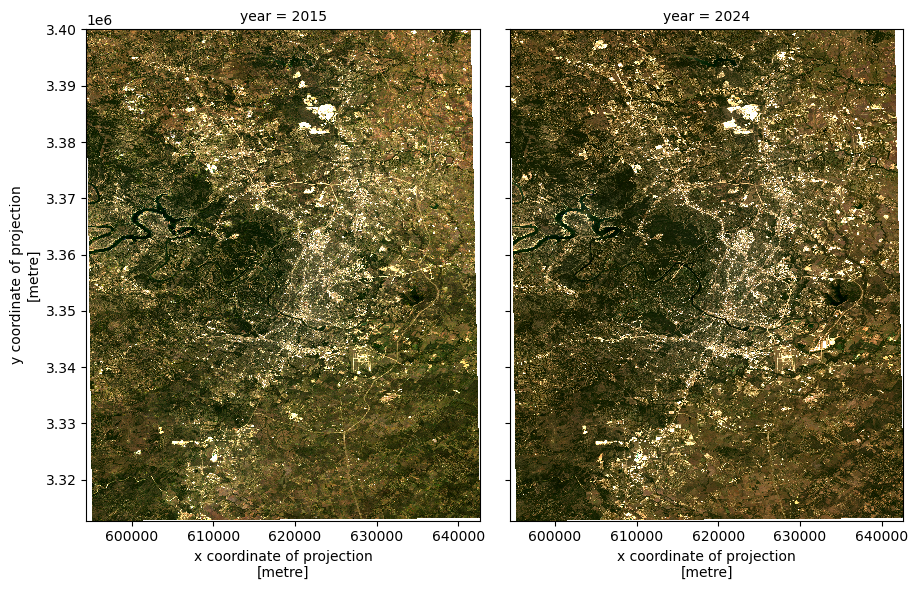

In [62]:
rgb(ds_mask_scaled_sel,bands=['B04','B03','B02'],col='year',aspect=0.7)

## 4.2. ENDISI Estimation
The Enhanced Normalized Difference Impervious Surfaces Index (ENDISI) is a recently developed urbanisation proxy that has been shown to work well in a variety of environments (Chen et al. 2020). Like all normalised difference indicies, it has a range of [-1, 1]. Note that MNDWI, swir_diff and alpha are all part of the ENDISI calculation




In [64]:
# Calculate the ENDISI index
blue_band = 'B02'
green_band = 'B03'
swir1_band = 'SWIR1'
swir2_band = 'SWIR2'
ds_mask_scaled['ENDISI'] = ENDISI(ds_mask_scaled,blue_band,green_band,swir1_band,swir2_band)


Plot to show the urban areas

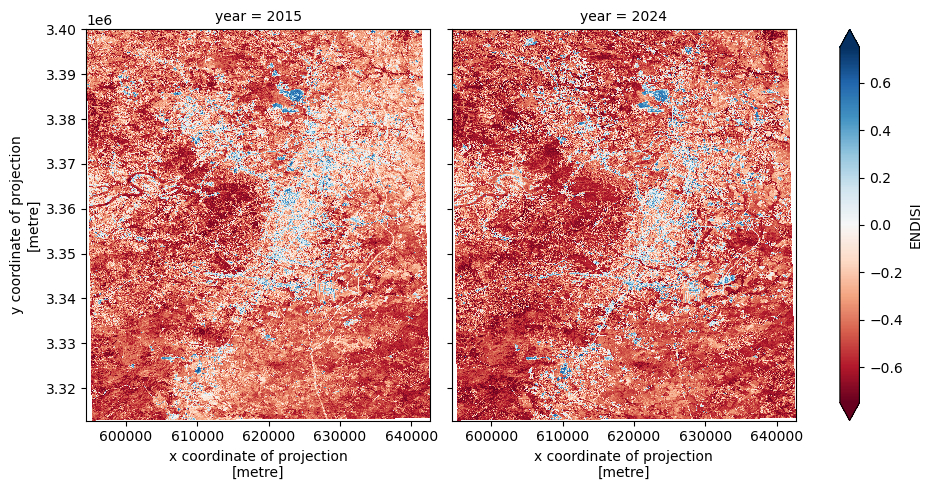

In [65]:
ds_mask_scaled.ENDISI.plot(col='year',vmin=-.75,
                       vmax=0.75,
                       cmap='RdBu',
                       figsize=(10, 5),
                       robust=True);

Visualizing the statistical distribution by year

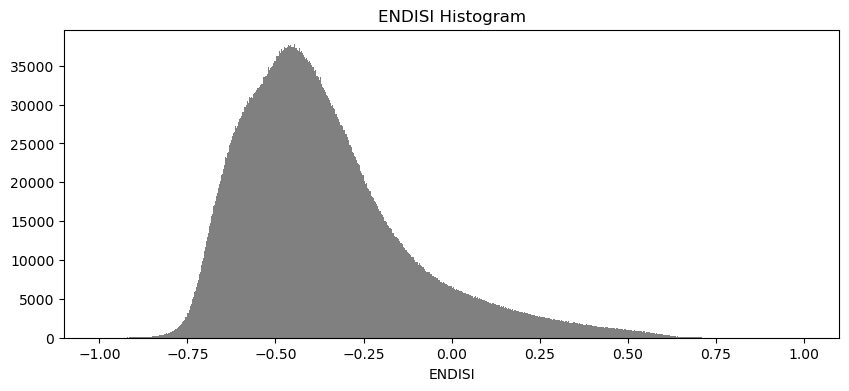

In [66]:
ds_mask_scaled.ENDISI.plot.hist(bins=1000,
                            range=(-1, 1),
                            facecolor='gray',
                            figsize=(10, 4))
plt.title('ENDISI Histogram');

## 4.3. Calculate Urban Extent

To define the urban extent, we need to threshold the ENDISI arrays. Values above this threshold will be labelled as 'Urban' while values below the trhehsold will be excluded from the urban extent. We can determine this threshold a number of ways (inluding by simply manually definining it e.g. threshold=-0.1). Below, we use the Otsu method to automatically threshold the image.

In [67]:
from skimage.filters import threshold_otsu
ds_mask_scaled_nan = ds_mask_scaled['ENDISI'].values.flatten()
ds_mask_scaled_nan = ds_mask_scaled_nan[~np.isnan(ds_mask_scaled_nan)]
threshold = threshold_otsu(ds_mask_scaled_nan)
print(round(threshold, 2))

-0.25


Apply the threshold to calculate urban extent

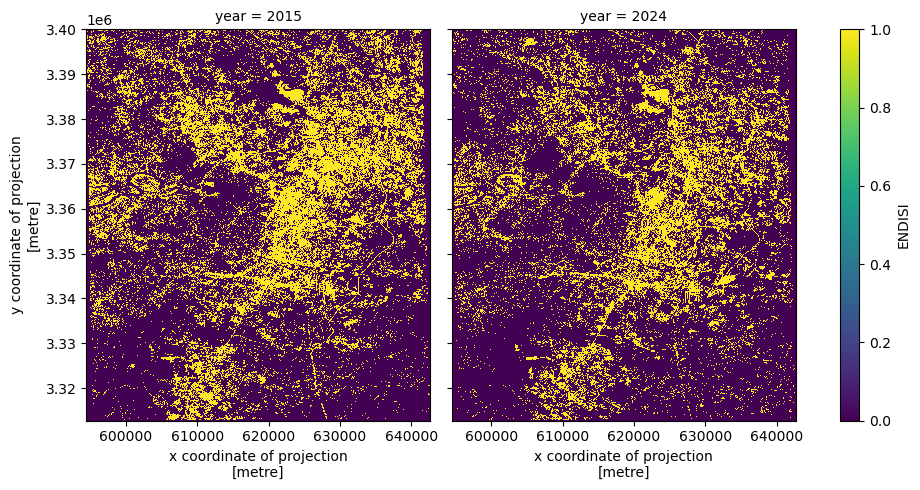

In [68]:
threshold = threshold
urban_area = (ds_mask_scaled.ENDISI > threshold).astype(int)
urban_area.plot(
    col='year',
    figsize=(10, 5),
    robust=True
)

## 4.7 Urban change

If we subtract the ENDISI of the baseline year from the analysis year, we can highlight regions where urban growth is occurring. To ensure we aren't capturing all change, we can set a change threshold, beyond which we distinguish between real change from background variation.

In this plot, we can see areas that have seen significant change, highlighting regions of urbanisation.



In [69]:
change_threshold = 0.15

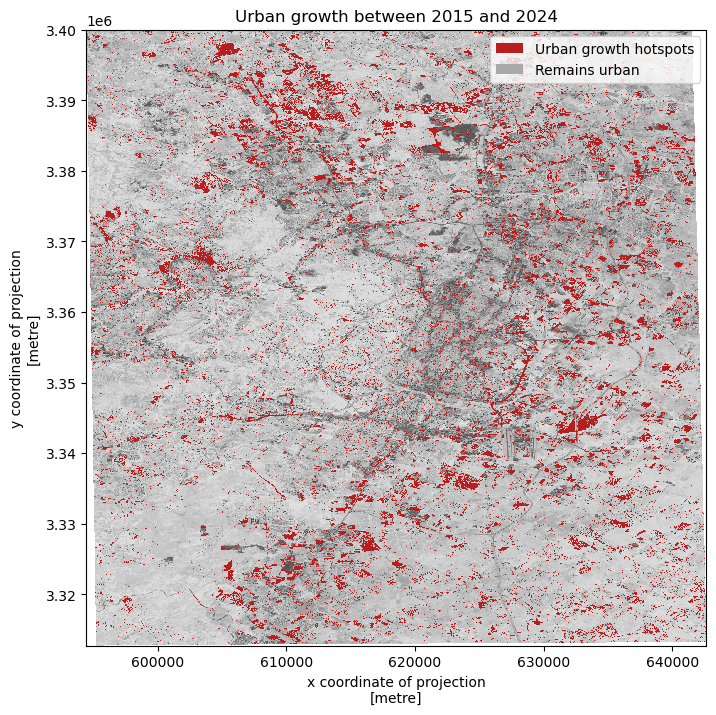

In [70]:
urban_growth_plot(ds_mask_scaled,baseline_year,analysis_year,change_threshold)

_______________________________________________________________________________________________________________________________________
# Additional information

**Contact**: Trang Vo (tv0015@uah.edu) - NASA-IMPACT UAH LAS. 

**Last modified**: April 2025